In [1]:
from time import sleep
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import os, re, json


# 啟動瀏覽器工具
my_options = webdriver.ChromeOptions()
my_options.add_argument("--start-maximized") 
my_options.add_argument("--incognito")          
my_options.add_argument("--disable-popup-blocking") 
my_options.add_argument("--disable-notifications")

In [2]:
def searchLoca(location):
    global locaUrl
    # 點擊民宿&公寓選項
    homeBtn = driver.find_element(By.CSS_SELECTOR, 'li#tab-home').click()
    sleep(1)

    # 搜尋地點關鍵字
    locaInput = driver.find_element(By.CSS_SELECTOR, 'input#textInput'
    ).send_keys(location)
    sleep(1)

    # 隱藏搜尋推薦窗
    driver.execute_script("""
    var popup = document.getElementById('search-box-autocomplete-id');
    if (popup) {
        popup.style.display = 'none';
    }
    """)
    sleep(1)

    # 按下搜尋 => agoda 設定會跳出新分頁
    searchBtn = driver.find_element(By.CSS_SELECTOR, '#Tabs-Container > button'
    ).click()
    sleep(1)

    # 切換到新的分頁 => 取得目前的URL
    all_windows = driver.window_handles
    if len(all_windows) > 1:
        driver.switch_to.window(all_windows[-1]) 
    locaUrl = driver.current_url

In [3]:
def inputInfo(checkIn_Year, checkIn_Month, checkIn_Date, checkOut_Year, checkOut_Month, checkOut_Date, rooms = 1, adults = 2, children = 0):
    global locaUrl
    # 正則選擇並修改入住日、退房日、人數、房數
    # 可以是使用者輸入
    # 可以是廣泛爬取每一天看空房數量=> 明確得知淡旺季
    checkIn_Year = 1911 + checkIn_Year if checkIn_Year < 1911 else str(checkIn_Year)
    checkIn_Month = '0' + str(checkIn_Month) if checkIn_Month < 10 else str(checkIn_Month)
    checkIn_Date = '0' + str(checkIn_Date + 1) if (checkIn_Date + 1) < 10 else str(checkIn_Date + 1)

    checkOut_Year = 1911 + checkOut_Year if checkOut_Year < 1911 else str(checkOut_Year)
    checkOut_Month = '0' + str(checkOut_Month) if checkOut_Month < 10 else str(checkOut_Month)
    checkOut_Date = '0' + str(checkOut_Date + 1) if (checkOut_Date + 1) < 10 else str(checkOut_Date + 1)

    inputInfo = f"checkIn={checkIn_Year}-{checkIn_Month}-{checkIn_Date}&checkOut={checkOut_Year}-{checkOut_Month}-{checkOut_Date}&rooms={rooms}&adults={adults}&children={children}"
    reUrl = r"checkIn=(\d{4})-(\d{2})-(\d{2})&checkOut=(\d{4})-(\d{2})-(\d{2})&rooms=(\d{1,2})&adults=(\d{1,2})&children=(\d{1,2})"

    targetUrl = re.sub(reUrl, inputInfo, locaUrl)
    driver.get(targetUrl)

In [4]:
def scrollPage():
    count = 0
    limit = 3
    innerHeight = 0
    offset = 0
    while count <= limit:

        # 拿到可滾動高度
        offset = driver.execute_script(
            'return document.documentElement.scrollHeight;'
        )
        # 卷軸滾指定距離
        driver.execute_script(f'''
            window.scrollBy({{
                top: 1000,
                behavior: 'smooth'
            }});
            ''')
        sleep(2)

        # 取得捲動後的當前總高度
        innerHeight = driver.execute_script(
            'return document.documentElement.scrollHeight;'
        )

        # 確定還有沒有東西可以加載
        if offset == innerHeight:
            count += 1

In [5]:
def parse():
    # 尋找列表每一個資料
    hotelItems = 'ol.hotel-list-container li[data-selenium="hotel-item"]'
    elements = driver.find_elements(By.CSS_SELECTOR, hotelItems)

    # 再取每一個區塊裡的連結
    for elm in elements:
        # 取得名宿名稱
        name = elm.find_element(
            By.CSS_SELECTOR,
            'h3[data-selenium="hotel-name"]'
        )
        hotelName = name.get_attribute('innerHTML')

        # 取得民宿內文連結
        a = elm.find_element(
            By.CSS_SELECTOR,
            'a.PropertyCard__Link'
        )
        hotelUrl = a.get_attribute('href')

        # 取得名宿地點
        label = elm.find_element(
            By.CSS_SELECTOR,
            'button[data-selenium="area-city-text"] > span'
        )
        hotelLocation = label.get_attribute('label')
        

        # 取得價錢
        try:
            money = elm.find_element(
                By.CSS_SELECTOR,
                'span.PropertyCardPrice__Value'
            )
            hotelPrice = money.get_attribute('innerHTML')

        except NoSuchElementException:
            hotelPrice = "已售罄"
        
        #丟到 list
        listData.append({
            'name': hotelName,
            'link': hotelUrl,
            'location': hotelLocation,
            'price': hotelPrice
        })

In [6]:
def saveJson():
    os.makedirs('agoda', exist_ok=True) 
    with open(f'./agoda/houselist.json', "w", encoding = "utf-8") as file:
        file.write(
            json.dumps(listData, ensure_ascii=False, indent=4)
        )

In [7]:
locaUrl = ''
listData = []
listData.clear()

driver = webdriver.Chrome(options = my_options)
url = 'https://www.agoda.com/'
driver.get(url)
sleep(1)

searchLoca('宜蘭')
inputInfo(2025, 9, 5, 2025, 9, 6, 1, 10, 0)

while True:
    scrollPage()
    sleep(2)
    parse()
    try:
        nextpageBtn = driver.find_element(By.CSS_SELECTOR, 'button#paginationNext').click()
    except (NoSuchElementException, TimeoutException):
        saveJson()
        print('完成爬取資料，已寫入檔案！')
        break
    else:
        sleep(2)



完成爬取資料，已寫入檔案！


In [8]:
import pandas as pd
# pprint(listData)

# 假設你的資料是 listData
data = listData

# 轉成 DataFrame
df = pd.DataFrame(data)

# 處理 '已售罄' 和字串中的逗號
df = df[df['price'] != '已售罄']
df['price'] = df['price'].str.replace(',', '').astype(int)

# 分離出 鄉鎮、縣市
df['town'] = df['location'].apply(lambda x: x.split(',')[0])
df['city'] = df['location'].apply(lambda x: x.split(',')[1].split('-')[0].strip())

df.head(20)

,name,link,location,price,town,city
0,天送幸福和苑 (Tian Song Villa),https://www.agoda.com/zh-tw/h58891100/hotel/yi...,"三星鄉, 宜蘭縣 - 距市中心14.2公里",16071,三星鄉,宜蘭縣
1,古舍古鄉 (Old House Homestay),https://www.agoda.com/zh-tw/old-house-homestay...,"大同鄉, 宜蘭縣 - 距市中心19.0公里",10174,大同鄉,宜蘭縣
2,沃客宅 (Walk in house),https://www.agoda.com/zh-tw/walk-in-house/hote...,"員山鄉, 宜蘭縣 - 距市中心8.8公里",29504,員山鄉,宜蘭縣
4,禾畔の民宿-近冬山河童玩節-ktv烤肉包棟,https://www.agoda.com/zh-tw/ktv/hotel/all/yila...,"冬山鄉, 宜蘭縣 - 位於市中心",18615,冬山鄉,宜蘭縣
5,羅東沐石,https://www.agoda.com/zh-tw/luodong-night-mark...,"羅東鎮, 宜蘭縣 - 位於市中心",6926,羅東鎮,宜蘭縣
6,九塘苑 (9 Tan Yuan Homestay),https://www.agoda.com/zh-tw/h22664507/hotel/ta...,"礁溪鄉, 宜蘭縣 - 距市中心14.6公里",8890,礁溪鄉,宜蘭縣
7,宜蘭烏石驛站民宿,https://www.agoda.com/zh-tw/h50620383/hotel/al...,"頭城鎮, 宜蘭縣 - 距市中心20.0公里",13680,頭城鎮,宜蘭縣
8,冬杉荷民宿 (Dong Shan He B&amp;B),https://www.agoda.com/zh-tw/dong-shan-he-b-b_2...,"冬山鄉, 宜蘭縣 - 位於市中心",7224,冬山鄉,宜蘭縣
9,蘇澳鎮的4臥室獨棟住宅 - 117平方公尺/5間專用衛浴 (JIURI),https://www.agoda.com/zh-tw/jiuri/hotel/yilan-...,"蘇澳鎮, 宜蘭縣 - 距市中心11.1公里",7723,蘇澳鎮,宜蘭縣
10,礁溪鄉的4臥室 - 300平方公尺/5間專用衛浴 (十月 Mooon House),https://www.agoda.com/zh-tw/mooon-house-h73648...,"頭城鎮, 宜蘭縣 - 距市中心17.0公里",10472,頭城鎮,宜蘭縣


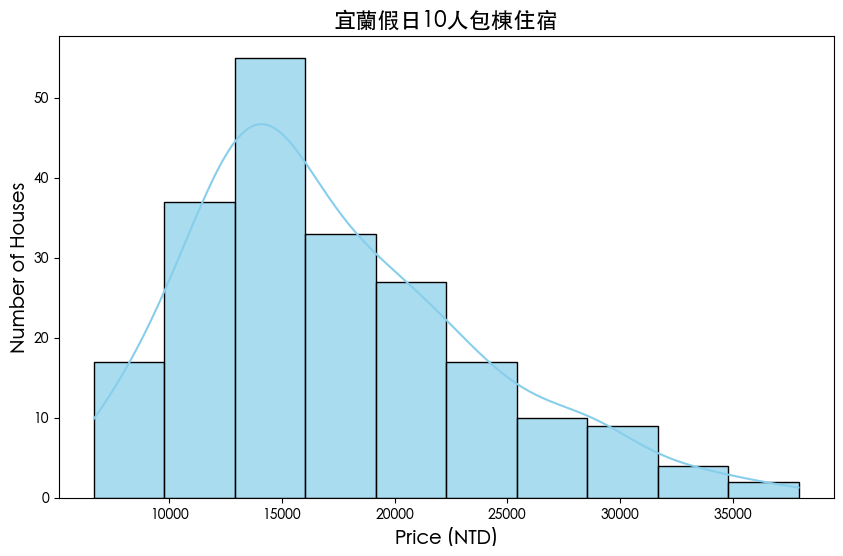

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定中文
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 中文字型
plt.rcParams['axes.unicode_minus'] = False  # 負號正常顯示

# 剔除極端值：保留 1% ~ 99% 的價格
lower_bound = df['price'].quantile(0.01)
upper_bound = df['price'].quantile(0.99)
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# 畫圖
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['price'], bins=10, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('宜蘭假日10人包棟住宿', fontsize=16)
plt.xlabel('Price (NTD)', fontsize=14)
plt.ylabel('Number of Houses', fontsize=14)
plt.show()

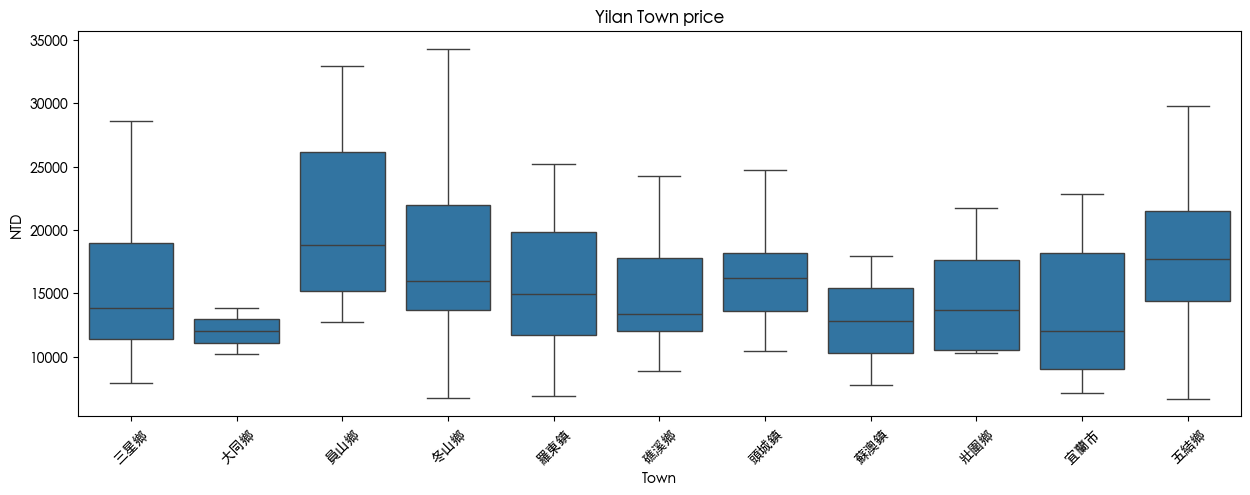

In [28]:
# 鄉鎮 vs 價格的箱型圖
plt.figure(figsize=(15, 5))
# 不畫離群值 
sns.boxplot(x='town', y=df_filtered['price'], data=df, showfliers=False) 
plt.xticks(rotation=45)
plt.title('Yilan Town price')
plt.xlabel('Town')
plt.ylabel('NTD')
plt.show()

In [12]:
# 取得該日期房間總數量
allNum = driver.find_element(By.CSS_SELECTOR, '#autocomplete-box div.SearchBoxTextDescription__desc')
availHotel = allNum.get_attribute('innerHTML')